In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import scipy
from scipy import optimize
from scipy.optimize import leastsq
from io import StringIO
from scipy.signal import savgol_filter
from datetime import datetime

now = datetime.now()
d_string = now.strftime("%d.%m.%Y")



<Figure size 432x288 with 0 Axes>

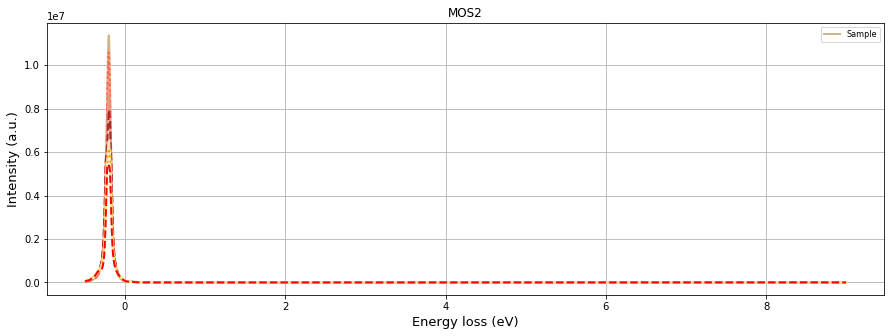

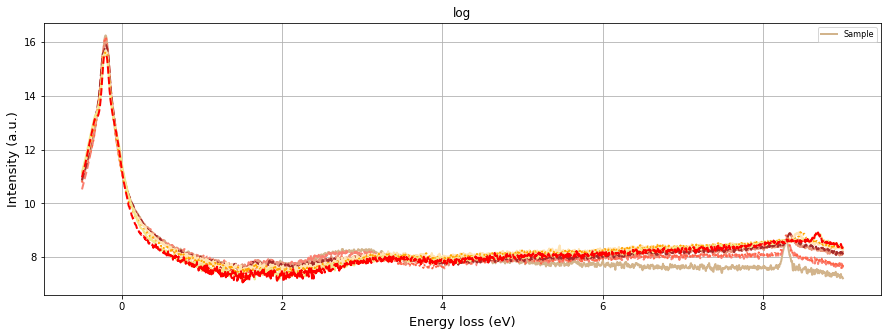

In [114]:
%run EELS-ZLP-May.py

## Load predictions and training data

In [179]:
path_1 = r'Data/Results/%(now)s/' % {"now": d_string} # use your path
path_2 = r'x2_xyp1p2_*round4*.csv'
all_files = glob.glob(path_1 + path_2)
li = []

for filename in all_files:
    df = pd.read_csv(filename, delimiter=",", skiprows=1, header=None, usecols=[0,1,2], names=['x', 'y', 'pred'])
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)


In [180]:
pseudo_x = frame.iloc[:,0]
pseudo_y = frame.iloc[:,1]
pseudo_pred = frame.iloc[:,2]


## Load Chi2 training data

In [181]:
path_3 = r'x2_chi_*round4*.csv' 

all_files_chi = glob.glob(path_1 + path_3)

all_files_chi_sort = np.sort(all_files_chi)
chi2_array = []
chi2_index = []

for filename in all_files_chi_sort:
    df = pd.read_csv(filename, delimiter=",", skiprows=1, header=None, usecols=[0,1])
    best_try = np.argmin(df[1])
    chi2_array.append(df.iloc[best_try,1])
    chi2_index.append(best_try)
    
print(chi2_array)

[1.246161, 29.633847999999997, 0.895869, 27.717484999999996, 1.192205, 1.182643, 2.3986959999999997, 28.391308000000002, 1.1989940000000001, 23.684629, 1.51966, 27.715141, 1.236987, 27.863008, 1.099148, 30.421661, 0.7149439999999999, 28.527497999999998, 0.575986, 2.986916]


## Post-selection criteria

In [182]:
good_files = []

for i,j in enumerate(chi2_array):
    selection_min = 1.7
    if j < selection_min:
        good_files.append('Keep') 
    else:
        good_files.append('Discard')
print((good_files))

['Keep', 'Discard', 'Keep', 'Discard', 'Keep', 'Keep', 'Discard', 'Discard', 'Keep', 'Discard', 'Keep', 'Discard', 'Keep', 'Discard', 'Keep', 'Discard', 'Keep', 'Discard', 'Keep', 'Discard']


## Load extrapolation data

In [183]:
path_4 = r'x2_extrapolation_*round4*'
all_files_ex = glob.glob(path_1 + path_4)
all_files_ex_sort = np.sort(all_files_ex)
use_files = []

for i,j in enumerate(good_files):
    if j == 'Keep':
        file = all_files_ex_sort[i]
        use_files.append(file)

high_energy = []
#del all_files_ex[3]

for filename in use_files:
    df = pd.read_csv(filename, delimiter=",", header=None, usecols=[0,1], names=['dE', 'D'])
    high_energy.append(df)
extrapolation = pd.concat(high_energy, axis=0, ignore_index=True)


In [184]:
#np.savetxt('Data/Results/05.05.2020/10ms_180keV', extrapolation)

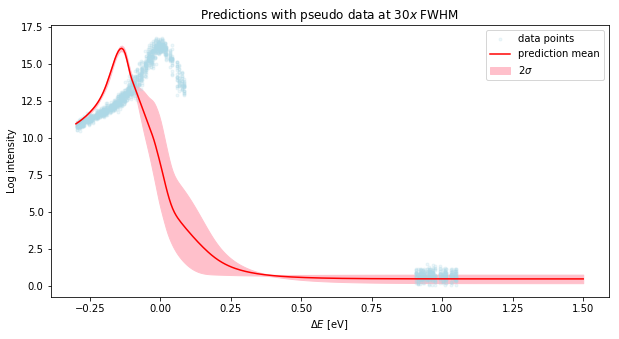

In [185]:
%run Functions.ipynb

x = extrapolation['dE']
x = np.interp(x, (x.min(), x.max()), (-0.3, 1.5))
y = extrapolation['D']

nbins = 300
mean, var, count = binned_statistics(x,y)

plt.figure(figsize=(10,5))
plt.plot(pseudo_x, pseudo_y, '.',color='lightblue', alpha=.2,  label='data points')
plt.fill_between(np.linspace(-0.3,1.5,nbins), mean + var, mean - var, color='pink', label='$2\sigma$')
plt.plot(np.linspace(-0.3,1.5,nbins), mean, color='red', label='prediction mean')


plt.xlabel('$\Delta E$ [eV]')
#plt.xlim([-0.2, 0.2])
plt.ylabel('Log intensity')
plt.title('Predictions with pseudo data at 30$x$ FWHM')
#plt.savefig('Data/Results/realdeal1.png')
#plt.xlim([-0.65, -.20])

plt.legend()

plt.show()


## plots

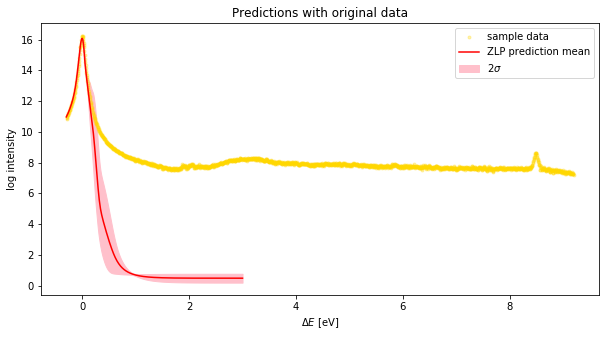

In [192]:
plt.figure(figsize=(10,5))
plt.plot(x1+0.2025, log_y1, '.', color='gold', alpha=.3, label='sample data')
plt.fill_between(np.linspace(-0.3,3,nbins), mean + var, mean - var, color='pink', label='$2\sigma$')
plt.plot(np.linspace(-0.3,3,nbins), mean, color='red', label='ZLP prediction mean')
plt.title('Predictions with original data')
plt.ylabel('log intensity')
plt.xlabel('$\Delta E$ [eV]')
plt.legend()



## Find mean and std of the predictions
